In [125]:
from fastai.tabular import *
from pathlib import Path
import pandas as pd
from fastai import *
from fastai.tabular import *
from fastai.callbacks import *
from fastai.text import *
from fastai.metrics import accuracy, MultiLabelFbeta

In [126]:
bs = 64

# Creating a tab+ NLP model 

load previous models 


# NLP model 

In [127]:
learn_nlp = load_learner('.','final_nlp_word.pkl')
learn_nlp.model[-1].layers = learn_nlp.model[-1].layers[:-3] 
learn_nlp.model


SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(6880, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(6880, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
    )
  )
)

In [128]:
flatten_model(learn_nlp.model)

[Embedding(6880, 400, padding_idx=1),
 Embedding(6880, 400, padding_idx=1),
 LSTM(400, 1152, batch_first=True),
 LSTM(1152, 1152, batch_first=True),
 LSTM(1152, 400, batch_first=True),
 RNNDropout(),
 RNNDropout(),
 RNNDropout(),
 RNNDropout(),
 BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Dropout(p=0.2, inplace=False),
 Linear(in_features=1200, out_features=50, bias=True),
 ReLU(inplace=True)]

## Load tabular learner 

In [129]:
learn_tab = load_learner('.','final_tab.pkl')

In [130]:
learn_tab

Learner(data=TabularDataBunch;

Train: LabelList (0 items)
x: TabularList

y: CategoryList

Path: .;

Valid: LabelList (0 items)
x: TabularList

y: CategoryList

Path: .;

Test: None, model=TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(9453, 269)
    (2): Embedding(1997, 113)
    (3): Embedding(279, 37)
    (4): Embedding(56, 15)
    (5): Embedding(13, 7)
    (6): Embedding(2, 2)
  )
  (emb_drop): Dropout(p=0.05, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=446, out_features=432, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(432, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=432, out_features=24, bias=True)
  )
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=CrossEntropyLoss(), metrics=[<function 

# Grab up to ReLU

In [131]:
learn_tab.model.layers = learn_tab.model.layers[:-3]
learn_tab.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(9453, 269)
    (2): Embedding(1997, 113)
    (3): Embedding(279, 37)
    (4): Embedding(56, 15)
    (5): Embedding(13, 7)
    (6): Embedding(2, 2)
  )
  (emb_drop): Dropout(p=0.05, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=446, out_features=432, bias=True)
    (1): ReLU(inplace=True)
  )
)

# Concat dataset

In [132]:
class ConcatDataset(Dataset):
    def __init__(self, x1, x2, y): 
        self.x1,self.x2,self.y = x1,x2,y
    def __len__(self): 
        return len(self.y)
    def __getitem__(self, i): 
        return (self.x1[i], self.x2[i]), self.y[i]

# Load datasets

In [133]:
data_tab = load_data('.','tab_data')
data_nlp = load_data('.', 'nlp_data')

# Create ConcatDatasets for tab and NLP 

In [134]:
train_ds = ConcatDataset(data_tab.train_ds.x, data_nlp.train_ds.x, data_tab.train_ds.y)
valid_ds = ConcatDataset(data_tab.valid_ds.x, data_nlp.valid_ds.x, data_tab.valid_ds.y)

In [135]:
# 

In [136]:
def collate(batch):    
    x,y = list(zip(*batch))
    x1,x2 = list(zip(*x))
    x1 = to_data(x1)
    x1 = list(zip(*x1))
    x1 = torch.stack(x1[0]), torch.stack(x1[1])
    x2, y = pad_collate(list(zip(x2, y)), pad_idx=1, pad_first=True)
    return (x1, x2), y

In [137]:
# Go through the text data by order of length with a bit of randomness.
train_sampler = SortishSampler(data_nlp.train_ds.x, key=lambda t: len(data_nlp.train_ds[t][0].data), bs=bs//2)

# Go through the text data by order of length.
valid_sampler = SortSampler(data_nlp.valid_ds.x, key=lambda t: len(data_nlp.valid_ds[t][0].data))

In [138]:
train_dl = DataLoader(train_ds, bs, sampler=train_sampler)
valid_dl = DataLoader(valid_ds, bs, sampler=valid_sampler)
data = DataBunch(train_dl, valid_dl, device=defaults.device, collate_fn=collate, path='.')

In [139]:
class ConcatModel(nn.Module):
    def __init__(self, model_tab, model_nlp, layers, drops): 
        super().__init__()
        self.model_tab = model_tab
        self.model_nlp = model_nlp
        lst_layers = []
        activs = [nn.ReLU(inplace=True),] * (len(layers)-2) + [None]
        for n_in,n_out,p,actn in zip(layers[:-1], layers[1:], drops, activs): 
            lst_layers += bn_drop_lin(n_in, n_out, p=p, actn=actn) # https://docs.fast.ai/layers.html#bn_drop_lin
        self.layers = nn.Sequential(*lst_layers)

    def forward(self, *x):
        x_tab = self.model_tab(*x[0])
        x_nlp = self.model_nlp(x[1])[0]
        x = torch.cat([x_tab, x_nlp], dim=1)
        return self.layers(x)   

## Layer groups 

Layer groups allow us to use the fastai freeze layers approach to train some layers more or turn off training on some layers. 

```flatten_model``` allows you to acccess the model as an array making it easy to grab the bits you want

In [140]:
m = simple_cnn([3,6,12])
m

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(6, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (2): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten()
  )
)

In [141]:
m[0]

Sequential(
  (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU(inplace=True)
)

In [142]:
print(flatten_model(m)[0])
print('-*-')
print(flatten_model(m)[1])


Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
-*-
ReLU(inplace=True)


In [143]:
lin_layers = [432+50, 24]
ps = [0.8]
model = ConcatModel(learn_tab.model, learn_nlp.model, lin_layers, ps)
model

ConcatModel(
  (model_tab): TabularModel(
    (embeds): ModuleList(
      (0): Embedding(3, 3)
      (1): Embedding(9453, 269)
      (2): Embedding(1997, 113)
      (3): Embedding(279, 37)
      (4): Embedding(56, 15)
      (5): Embedding(13, 7)
      (6): Embedding(2, 2)
    )
    (emb_drop): Dropout(p=0.05, inplace=False)
    (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): Linear(in_features=446, out_features=432, bias=True)
      (1): ReLU(inplace=True)
    )
  )
  (model_nlp): SequentialRNN(
    (0): MultiBatchEncoder(
      (module): AWD_LSTM(
        (encoder): Embedding(6880, 400, padding_idx=1)
        (encoder_dp): EmbeddingDropout(
          (emb): Embedding(6880, 400, padding_idx=1)
        )
        (rnns): ModuleList(
          (0): WeightDropout(
            (module): LSTM(400, 1152, batch_first=True)
          )
          (1): WeightDropout(
            (module): LSTM(1152, 1152, batch_first=T

In [144]:
layer_groups = [nn.Sequential(*flatten_model(learn_nlp.layer_groups[0][0])),
                nn.Sequential(*flatten_model(learn_nlp.layer_groups[0][1])),
                nn.Sequential(*flatten_model(learn_nlp.layer_groups[0][2])),
                nn.Sequential(*flatten_model(learn_nlp.layer_groups[0][3])),
                nn.Sequential(*(flatten_model(learn_nlp.layer_groups[0][4]) + 
                                flatten_model(model.model_tab) +
                                flatten_model(model.layers)))] 

In [145]:
loss_func = nn.CrossEntropyLoss()
f1 = FBeta(average='macro')

In [146]:
learn = Learner(data, model, loss_func=loss_func, metrics=[accuracy, f1],layer_groups=layer_groups)

In [147]:
learn.layer_groups

[Sequential(
   (0): Embedding(6880, 400, padding_idx=1)
 ),
 Sequential(
   (0): Embedding(6880, 400, padding_idx=1)
 ),
 Sequential(
   (0): LSTM(400, 1152, batch_first=True)
 ),
 Sequential(
   (0): LSTM(1152, 1152, batch_first=True)
 ),
 Sequential(
   (0): LSTM(1152, 400, batch_first=True)
   (1): Embedding(3, 3)
   (2): Embedding(9453, 269)
   (3): Embedding(1997, 113)
   (4): Embedding(279, 37)
   (5): Embedding(56, 15)
   (6): Embedding(13, 7)
   (7): Embedding(2, 2)
   (8): Dropout(p=0.05, inplace=False)
   (9): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): Linear(in_features=446, out_features=432, bias=True)
   (11): ReLU(inplace=True)
   (12): BatchNorm1d(482, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (13): Dropout(p=0.8, inplace=False)
   (14): Linear(in_features=482, out_features=24, bias=True)
 )]

In [148]:
learn.freeze()
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


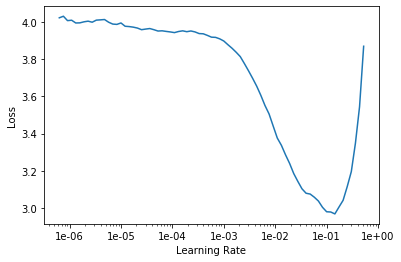

In [149]:
learn.recorder.plot()

In [150]:
learn.fit_one_cycle(20,max_lr=1e-02,
                   callbacks=[SaveModelCallback(learn, 
                                                monitor='f_beta',
                                                    every='improvement',
                                                     name='best_concat')])

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.113371,0.838347,0.647095,0.279346,00:23
1,1.089603,0.914679,0.641995,0.304304,00:23
2,1.160643,4.215755,0.602065,0.268427,00:22
3,1.148239,42.117195,0.618361,0.297646,00:22
4,1.136448,6246.448242,0.538997,0.215437,00:22
5,1.138130,9469.410156,0.501679,0.217541,00:22
6,1.175406,7264.843750,0.484762,0.225888,00:23
7,1.123514,11006.173828,0.493594,0.265888,00:23
8,1.091164,9225.922852,0.491479,0.201561,00:22
9,1.075040,9825.662109,0.467471,0.250131,00:22


Better model found at epoch 0 with f_beta value: 0.2793460190296173.
Better model found at epoch 1 with f_beta value: 0.30430373549461365.
Better model found at epoch 10 with f_beta value: 0.3397168815135956.
Better model found at epoch 19 with f_beta value: 0.34664449095726013.


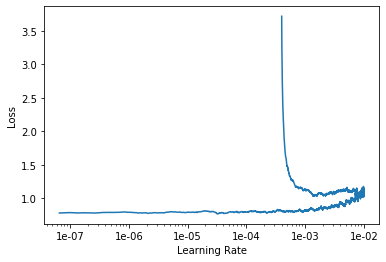

In [151]:
learn.recorder.plot()

In [152]:
learn.load('best_concat')

Learner(data=DataBunch;

Train: <__main__.ConcatDataset object at 0x7f3acc968090>;

Valid: <__main__.ConcatDataset object at 0x7f3acc968190>;

Test: None, model=ConcatModel(
  (model_tab): TabularModel(
    (embeds): ModuleList(
      (0): Embedding(3, 3)
      (1): Embedding(9453, 269)
      (2): Embedding(1997, 113)
      (3): Embedding(279, 37)
      (4): Embedding(56, 15)
      (5): Embedding(13, 7)
      (6): Embedding(2, 2)
    )
    (emb_drop): Dropout(p=0.05, inplace=False)
    (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): Linear(in_features=446, out_features=432, bias=True)
      (1): ReLU(inplace=True)
    )
  )
  (model_nlp): SequentialRNN(
    (0): MultiBatchEncoder(
      (module): AWD_LSTM(
        (encoder): Embedding(6880, 400, padding_idx=1)
        (encoder_dp): EmbeddingDropout(
          (emb): Embedding(6880, 400, padding_idx=1)
        )
        (rnns): ModuleList(
          (0): Weig

## Unfreeze some layers ❄️

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


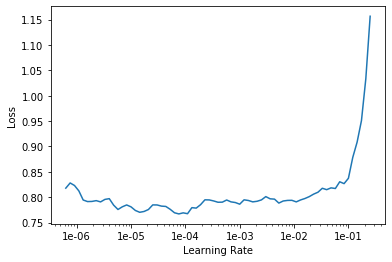

In [153]:
learn.freeze_to(-2) 
learn.lr_find()
learn.recorder.plot()

In [154]:
learn.fit_one_cycle(15, max_lr=slice(1e-06,1e-03),
                   callbacks=[SaveModelCallback(learn, 
                                                monitor='f_beta',
                                                    every='improvement',
                                                     name='best_concat[-2]')])

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.781668,8625.469727,0.475805,0.255952,00:36
1,0.779028,9978.281250,0.479040,0.264058,00:36
2,0.806826,6441.266602,0.581167,0.291540,00:34
3,0.782143,5626.436523,0.606419,0.304927,00:37
4,0.803760,6474.707520,0.594601,0.285145,00:36
5,0.800635,7983.955078,0.496579,0.267204,00:35
6,0.789283,6731.812988,0.527678,0.276695,00:34
7,0.810358,5825.984375,0.511631,0.259935,00:36
8,0.809235,3663.219971,0.605797,0.341057,00:34
9,0.805120,7313.948242,0.499067,0.259754,00:36


Better model found at epoch 0 with f_beta value: 0.25595155358314514.
Better model found at epoch 1 with f_beta value: 0.26405832171440125.
Better model found at epoch 2 with f_beta value: 0.2915395200252533.
Better model found at epoch 3 with f_beta value: 0.30492717027664185.
Better model found at epoch 8 with f_beta value: 0.3410570025444031.
Better model found at epoch 13 with f_beta value: 0.349485844373703.


In [155]:
learn.load('best_concat[-2]');

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


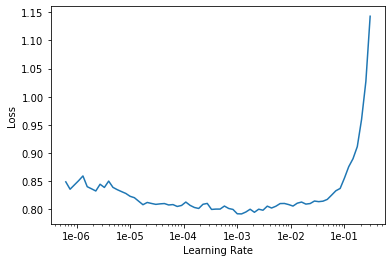

In [156]:
learn.freeze_to(-3)
learn.lr_find()
learn.recorder.plot()

In [157]:
learn.fit_one_cycle(20, max_lr=slice(1e-06,1e-03),
                     callbacks=[SaveModelCallback(learn, 
                                                monitor='f_beta',
                                                    every='improvement',
                                                     name='best_concat[-3]')])

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.760067,8230.521484,0.476676,0.249880,00:45
1,0.784613,6036.849121,0.597711,0.340378,00:45
2,0.794081,6972.509277,0.600199,0.353468,00:45
3,0.791946,6054.640625,0.495584,0.255091,00:47
4,0.794617,6708.648926,0.569847,0.312490,00:45
5,0.788234,5871.905273,0.596840,0.358306,00:45
6,0.789420,7859.240234,0.578803,0.292197,00:47
7,0.803559,7540.796387,0.470954,0.273770,00:47
8,0.792449,5396.727051,0.582784,0.321843,00:47
9,0.783216,4879.479980,0.592113,0.311778,00:44


Better model found at epoch 0 with f_beta value: 0.2498796582221985.
Better model found at epoch 1 with f_beta value: 0.3403783440589905.
Better model found at epoch 2 with f_beta value: 0.3534679710865021.
Better model found at epoch 5 with f_beta value: 0.35830649733543396.


In [158]:
learn.load('best_concat[-3]');

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


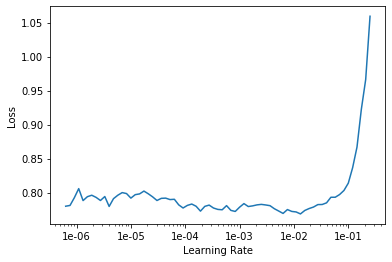

In [159]:
learn.freeze_to(-3)
learn.lr_find()
learn.recorder.plot()

In [160]:
learn.fit_one_cycle(40, max_lr=slice(1e-06,1e-03),
                    callbacks=[SaveModelCallback(learn, 
                                                monitor='f_beta',
                                                    every='improvement',
                                                     name='best_concat[-3b]')])

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.782279,3281.576172,0.579550,0.297383,00:44
1,0.780782,7456.487305,0.564622,0.308863,00:47
2,0.778966,6908.879883,0.522951,0.267317,00:46
3,0.774269,6406.083496,0.458639,0.213389,00:45
4,0.772803,8477.851562,0.579550,0.330660,00:46
5,0.780294,4407.409180,0.554173,0.297521,00:46
6,0.781079,3772.185547,0.533151,0.291758,00:45
7,0.789156,4106.123047,0.591616,0.301251,00:45
8,0.799142,3303.681396,0.599328,0.373016,00:46
9,0.795650,5403.567871,0.597711,0.298237,00:47


Better model found at epoch 0 with f_beta value: 0.29738321900367737.
Better model found at epoch 1 with f_beta value: 0.30886349081993103.
Better model found at epoch 4 with f_beta value: 0.3306603729724884.
Better model found at epoch 8 with f_beta value: 0.37301644682884216.
Better model found at epoch 10 with f_beta value: 0.398956835269928.


In [161]:
learn.load('best_concat[-3b]');

In [164]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.00E-05
Min loss divided by 10: 6.31E-08


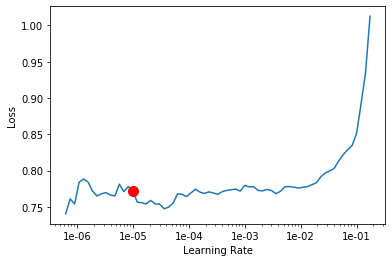

In [166]:
learn.recorder.plot(suggestion=True)

In [170]:
learn.fit_one_cycle(40, max_lr=1.00E-05,
                                       callbacks=[SaveModelCallback(learn,
                                                monitor='f_beta',
                                                    every='improvement',
                                                     name='best_concat[-4]')])(20, max_lr=slice(1e-06,1e-02))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.764931,3621.413574,0.591491,0.388761,00:45
1,0.755783,3631.050537,0.598831,0.377462,00:47
2,0.755915,3721.263916,0.595348,0.393412,00:47
3,0.774113,4787.080566,0.492225,0.295819,00:47
4,0.771144,7127.255371,0.464859,0.280464,00:48
5,0.753588,4453.768555,0.494962,0.295542,00:46
6,0.774551,3912.773438,0.568354,0.339032,00:44
7,0.761679,4531.391113,0.519468,0.299723,00:45
8,0.764477,4014.545654,0.604926,0.384431,00:47
9,0.762206,859.960388,0.617863,0.353547,00:46


Better model found at epoch 0 with f_beta value: 0.3887611925601959.
Better model found at epoch 2 with f_beta value: 0.39341238141059875.


TypeError: 'NoneType' object is not callable